### **Credit Risk Modeling**

##### **Importing Libraries**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
from optbinning import OptimalBinning, BinningProcess
from time import time
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from scipy.stats import chi2_contingency
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import shap

##### **Loading data file**

In [21]:
# Load the dataset
data = pd.read_csv('data/df_2014-15_selected.csv')

# Displaying basic information
print("Data shape:", data.shape)
print("\nData sample:")
print(data.head())
print("\nData summary:")
print(data.describe())

Data shape: (283134, 13)

Data sample:
   installment   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0       321.08   6611.690000          6611.69          5217.75   
1       319.08  19165.351925         19165.35         12800.00   
2       516.36  25512.200000         25512.20         21425.00   
3       468.17   5746.890000          5746.89          2628.14   
4       800.71  13907.790000         13907.79          7301.23   

   total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_amnt  \
0                 0.0      521.27                  93.8286           321.08   
1                 0.0        0.00                   0.0000          1576.08   
2                 0.0        0.00                   0.0000         17813.19   
3                 0.0     1515.55                 272.7990            50.00   
4                 0.0     3544.92                 638.0856           800.71   

   debt_settlement_flag  int_rate%  time_since_last_payment  \
0                     0   

##### **Checking the target column distribution**

loan_status_binary
1    228133
0     55001
Name: count, dtype: int64


C:\Users\aarun\AppData\Local\Temp\ipykernel_44028\275300849.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status_binary', data=data, palette='Set2')


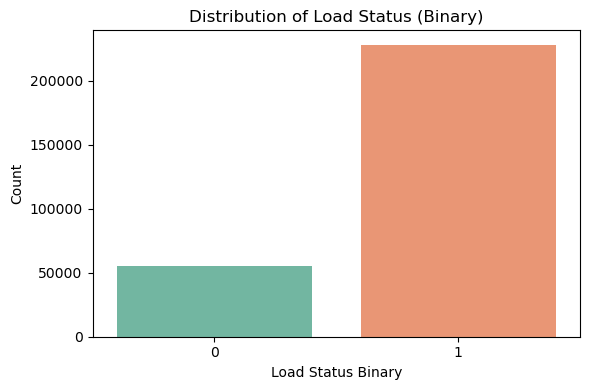

In [22]:
# Check the distribution
print(data['loan_status_binary'].value_counts())

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status_binary', data=data, palette='Set2')
plt.title('Distribution of Load Status (Binary)')
plt.xlabel('Load Status Binary')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


##### **Checking the columns**

In [23]:
data.columns

Index(['installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'debt_settlement_flag', 'int_rate%',
       'time_since_last_payment', 'time_since_last_credit_pull',
       'loan_status_binary'],
      dtype='object')

##### **Feature Engineering creating new column from existing column**

In [24]:
data['recovery_ratio'] = data['recoveries'] / (data['total_pymnt'] + 1e-6) 

data['late_fee_ratio'] = np.where(
    data['total_pymnt'] > 0,  # Only calculating if payments exist
    data['total_rec_late_fee'] / data['total_pymnt'],
    np.nan  # Returning NaN for loans with no payments
)

# Separating features and target
X = data.drop('loan_status_binary', axis=1)
y = data['loan_status_binary']

In [25]:
X.shape, y.shape


((283134, 14), (283134,))

##### **Data Spliting**

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### **Binning all the features**

In [27]:
features = X_train.columns
features

Index(['installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'debt_settlement_flag', 'int_rate%',
       'time_since_last_payment', 'time_since_last_credit_pull',
       'recovery_ratio', 'late_fee_ratio'],
      dtype='object')

##### **Binning process required to provide feature to binning and also mention the categorical features if available**\n
Binning process model learns the binning on X_train and y_train and transform the train and test respectively

In [28]:
from optbinning import BinningProcess

# Defining features and target
features_to_bin = X_train.columns.tolist()

# Initializing binning with WOE encoding
binner = BinningProcess(
    variable_names=features_to_bin,
    categorical_variables=["debt_settlement_flag"]
)

# Fit/transform
binner.fit(X_train, y_train)


# 3. Transforming data
X_train_binned = binner.transform(X_train)  # Get WOE-transformed features

X_test_binned = binner.transform(X_test) # Apply same rules to test



##### **After binning feature looks**

In [29]:
# Checking binning table for a feature like 'installment'
binning_table = binner.get_binned_variable("installment").binning_table
print(binning_table.build())


                     Bin   Count  Count (%)  Non-event   Event  Event rate  \
0         (-inf, 159.53)   17333   0.076523       2267   15066    0.869209   
1       [159.53, 222.28)   20568   0.090805       3018   17550    0.853267   
2       [222.28, 251.56)   11326   0.050003       1868    9458    0.835070   
3       [251.56, 335.38)   41165   0.181738       7962   33203    0.806583   
4       [335.38, 503.06)   60630   0.267674      12700   47930    0.790533   
5       [503.06, 549.49)   12032   0.053120       2805    9227    0.766872   
6       [549.49, 607.64)   11807   0.052126       2622    9185    0.777928   
7          [607.64, inf)   51646   0.228011      10745   40901    0.791949   
8                Special       0   0.000000          0       0    0.000000   
9                Missing       0   0.000000          0       0    0.000000   
Totals                    226507   1.000000      43987  182520    0.805803   

             WoE        IV            JS  
0      -0.471018  0.

##### **Binning for all feature look**

In [ ]:
# Re-transforming data to get bin labels instead of WOE
X_test_binned_labels = binner.transform(X_test, metric="bins")  
X_test_binned_labels

,installment,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,debt_settlement_flag,int_rate%,time_since_last_payment,time_since_last_credit_pull,recovery_ratio,late_fee_ratio
219972,"[607.64, inf)","[36920.31, inf)","[36830.21, inf)","[29970.78, inf)","(-inf, 0.44)","(-inf, inf)","(-inf, inf)","[7383.03, inf)",[1 0],"[17.06, 18.37)","[3008.50, 3100.50)","(-inf, 1975.00)","(-inf, inf)","(-inf, 0.00)"
142927,"[251.56, 335.38)","[16081.08, 21362.64)","[16057.68, 21347.89)","[14999.71, 19993.21)","(-inf, 0.44)","(-inf, inf)","(-inf, inf)","[7383.03, inf)",[1 0],"[11.11, 12.02)","[2949.50, 3008.50)","(-inf, 1975.00)","(-inf, inf)","(-inf, 0.00)"
135329,"[159.53, 222.28)","[5309.76, 8427.47)","[5320.55, 8427.04)","[4999.90, 7999.89)","(-inf, 0.44)","(-inf, inf)","(-inf, inf)","[98.82, 247.96)",[1 0],"[17.06, 18.37)","[2036.00, 2462.50)","(-inf, 1975.00)","(-inf, inf)","(-inf, 0.00)"
38814,"[549.49, 607.64)","[30137.79, 36920.31)","[30376.52, 36830.21)","[19993.21, 29970.78)","(-inf, 0.44)","(-inf, inf)","(-inf, inf)","(-inf, 98.82)",[1 0],"[17.06, 18.37)","[2554.00, 2643.50)","[1975.00, 2189.00)","(-inf, inf)","(-inf, 0.00)"
227078,"[251.56, 335.38)","[16081.08, 21362.64)","[16057.68, 21347.89)","[9999.84, 14999.71)","(-inf, 0.44)","(-inf, inf)","(-inf, inf)","[5142.31, 7383.03)",[1 0],"[14.64, 16.27)","[2036.00, 2462.50)","[2189.00, 2431.50)","(-inf, inf)","(-inf, 0.00)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252601,"[503.06, 549.49)","[26344.34, 30137.79)","[26313.49, 30376.52)","[7999.89, 9999.84)","(-inf, 0.44)","(-inf, inf)","(-inf, inf)","[434.02, 607.64)",[1 0],"[20.74, inf)","[2462.50, 2554.00)","[2189.00, 2431.50)","(-inf, inf)","(-inf, 0.00)"
115847,"[607.64, inf)","[10589.46, 13180.95)","[10580.82, 12946.06)","[4999.90, 7999.89)","[0.44, inf)","(-inf, inf)","(-inf, inf)","[869.76, 1283.46)",[1 0],"[10.57, 11.11)","[3008.50, 3100.50)","[2979.00, inf)","(-inf, inf)","[0.00, inf)"
280635,"(-inf, 159.53)","[3375.98, 5309.76)","[3375.98, 5320.55)","[4999.90, 7999.89)","(-inf, 0.44)","(-inf, inf)","(-inf, inf)","[3339.98, 5142.31)",[1 0],"[7.79, 9.03)","[3314.50, 3619.50)","(-inf, 1975.00)","(-inf, inf)","(-inf, 0.00)"
145882,"[251.56, 335.38)","[13180.95, 16081.08)","[12946.06, 16057.68)","[9999.84, 14999.71)","(-inf, 0.44)","(-inf, inf)","(-inf, inf)","(-inf, 98.82)",[1 0],"[12.54, 13.09)","(-inf, 2036.00)","(-inf, 1975.00)","(-inf, inf)","(-inf, 0.00)"


### **Logistic Regression Model**

In [ ]:
# Initialize model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

##### **Evaluation Function**

In [32]:
# Creating a function to evaluate and plot model results
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Training model
    model.fit(X_train, y_train)
    
    # Making predictions
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.predict(X_test)
    
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculating ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Calculating AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    # Print comprehensive report
    print(f"\n{model_name} Evaluation Report:")
    print("="*50)
    print(f"AUC-ROC: {auc:.4f}  AUC-PR: {auc_pr:.4f}  F1: {f1:.4f}")
    print("\nClassification Report:")

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print confusion matrix
    print(f"\n{model_name} Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    
    # Plot ROC and Precision-Recall curves
    plt.figure(figsize=(12, 5))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    # plt.show()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return model, auc, auc_pr, fpr, tpr, precision, recall, auc_pr, thresholds, conf_matrix, y_pred_proba

##### **Model Training**


Logistic Regression Evaluation Report:
AUC-ROC: 0.9847  AUC-PR: 0.9958  F1: 0.9743

Classification Report:

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     11014
           1       0.97      0.98      0.97     45613

    accuracy                           0.96     56627
   macro avg       0.94      0.92      0.93     56627
weighted avg       0.96      0.96      0.96     56627


Logistic Regression Confusion Matrix:
[[ 9463  1551]
 [  814 44799]]


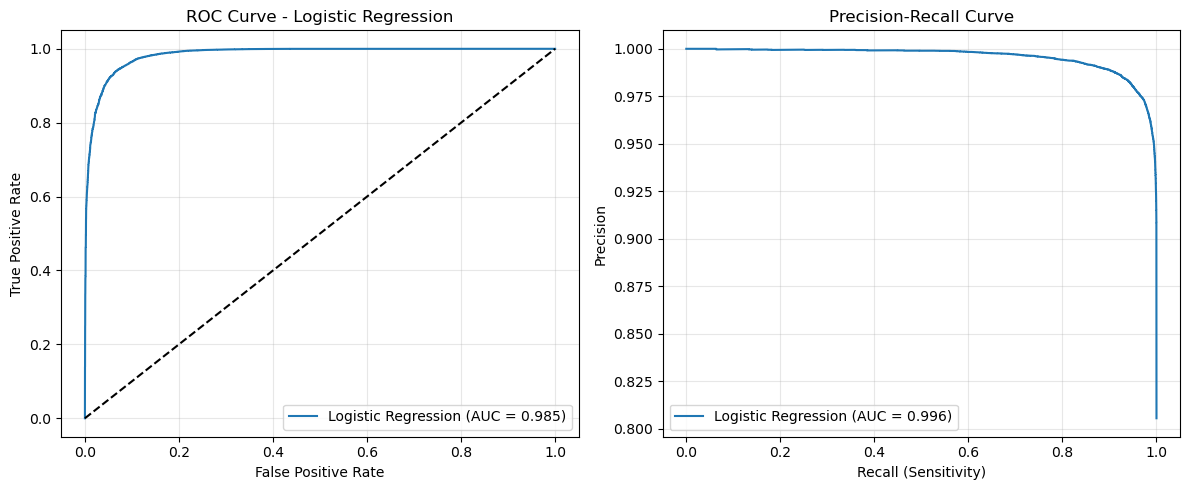


Logistic Regression Feature Importance:
                        Feature    Importance
0                   installment  8.718201e+00
3               total_rec_prncp  3.911749e+00
2               total_pymnt_inv  2.326157e+00
1                   total_pymnt  2.261567e+00
10      time_since_last_payment  1.145850e+00
7               last_pymnt_amnt  8.980897e-01
4            total_rec_late_fee  8.165111e-01
11  time_since_last_credit_pull  7.552317e-01
13               late_fee_ratio  5.907659e-01
9                     int_rate%  1.651843e-01
5                    recoveries  6.734115e-17
6       collection_recovery_fee  6.734115e-17
8          debt_settlement_flag  6.734115e-17
12               recovery_ratio  6.734115e-17


In [33]:
lr_model, lr_auc, lr_pr, lr_fpr, lr_tpr,lr_precision, lr_recall, lr_auc_pr, lr_thresholds, lr_conf_matrix, lr_pred_proba = evaluate_model(lr_model, X_train_binned, X_test_binned, y_train, y_test, "Logistic Regression")

# Geting feature importance for logistic regression
lr_importance = pd.DataFrame({
    'Feature': X_train_binned.columns,
    'Importance': np.abs(lr_model.coef_[0])
})
lr_importance = lr_importance.sort_values('Importance', ascending=False)

print("\nLogistic Regression Feature Importance:")
print(lr_importance.head(15))

##### **Ploting Feature Importance based on coefficient provided by the model**

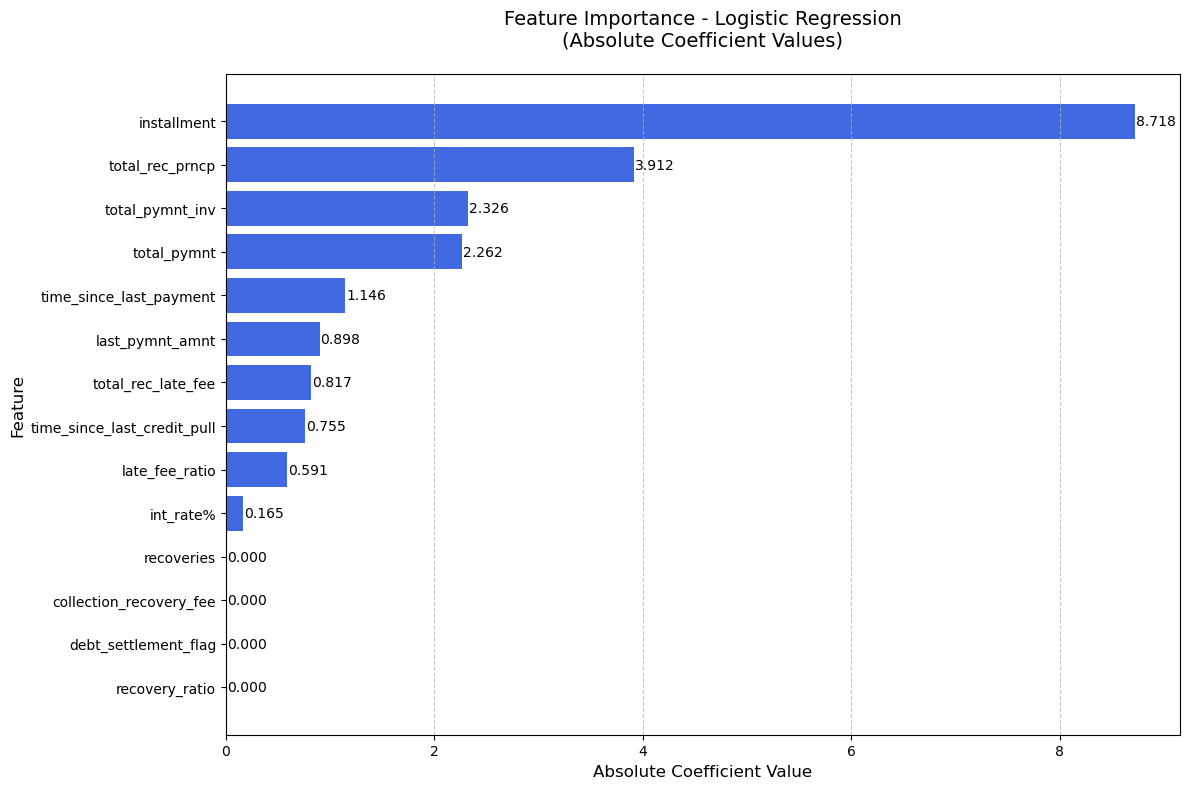

In [ ]:
plt.figure(figsize=(12, 8))

# Getting all features
top_features = lr_importance.head(15)

# Create horizontal bar plot
bars = plt.barh(top_features['Feature'], 
                top_features['Importance'], 
                color='royalblue')

# Adding value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             va='center')

# Customize appearance
plt.gca().invert_yaxis()  # highest importance at top
plt.title('Feature Importance - Logistic Regression\n(Absolute Coefficient Values)', 
          fontsize=14, pad=20)
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

##### **Visualizing using Shap Model**

In [ ]:
#SHAP Analysis on binned data
explainer = shap.Explainer(lr_model, X_train_binned)  # Background=training data
shap_values = explainer(X_test_binned)             # Explain test predictions

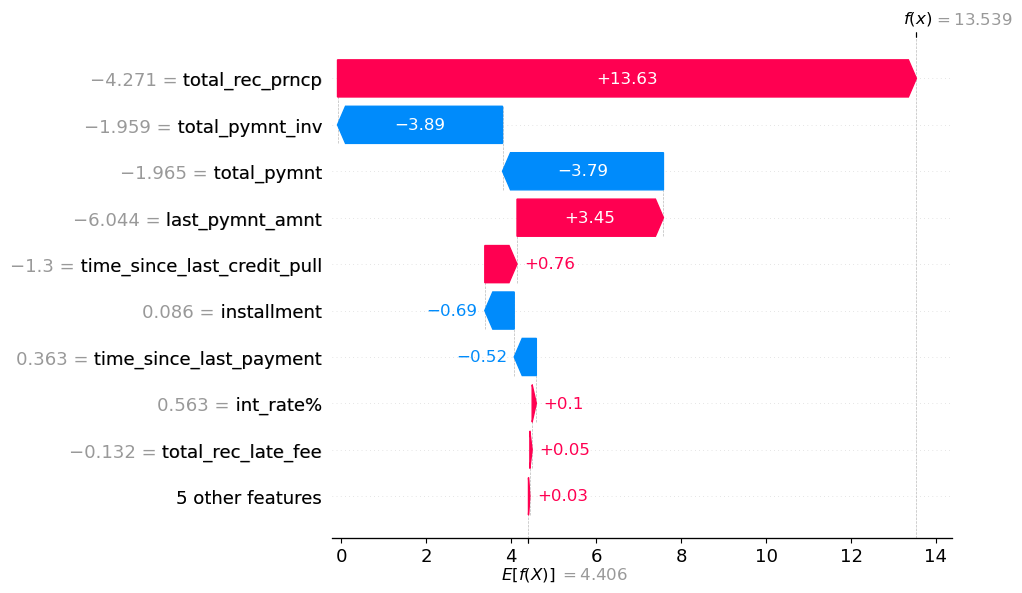

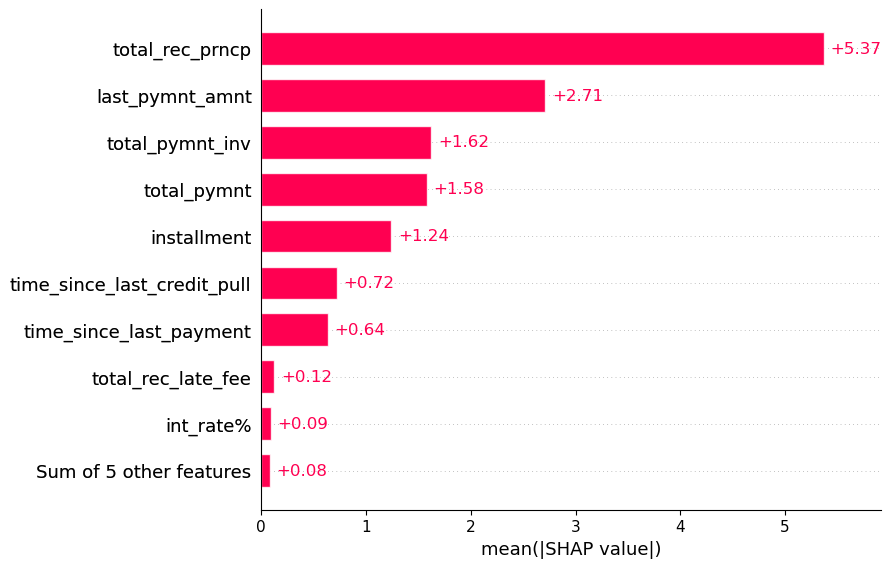

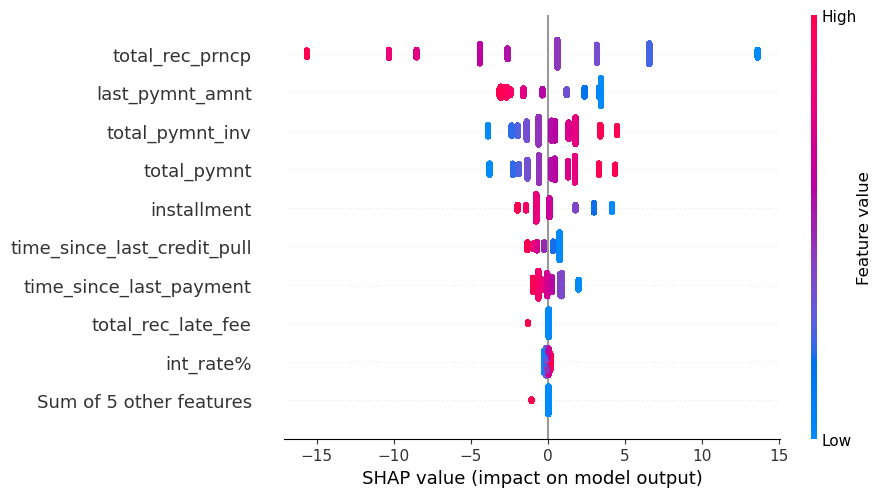

In [ ]:
#Visualizations for locan and global importance
# Waterfall plot shows Local importance
shap.plots.waterfall(shap_values[0])  # Individual case

# Bar plot (for global feature importance)
shap.plots.bar(shap_values[:, :, 0])

shap.plots.beeswarm(shap_values) # Global feature impact

##### **Scorecard Function**

In [ ]:
def calculate_score(prob, min_score=300, max_score=850):
    """
    Calculate credit score using log-odds transformation with scaling to ensure 
    scores fall within the min_score to max_score range.
    """
    # Converting probability of good outcome to probability of default
    default_prob = 1 - prob
    
    # Handling edge cases to avoid log(0) or division by zero
    default_prob = np.clip(default_prob, 0.001, 0.999)
    
    # Calculating log odds of default
    log_odds = np.log(default_prob / (1 - default_prob))
    
    # Assuming default_prob of 0.01 should map to score of 800
    # and default_prob of 0.5 should map to score of 350
    good_log_odds = np.log(0.01 / 0.99)  # ≈ -4.6
    bad_log_odds = np.log(0.5 / 0.5)    # = 0
    
    # Calculating factor using these points
    factor = (350 - 800) / (bad_log_odds - good_log_odds)
    
    # Calculating offset using one of the points
    offset = 800 - factor * good_log_odds
    
    # Apply transformation
    score = offset + factor * log_odds
    
    # Ensure scores stay within bounds
    score = np.clip(score, min_score, max_score)
    
    # Return rounded score
    return np.round(score).astype(int)

##### **Calculation of Youden's J statistic**

In [ ]:
# Adding scores to a sample of test data for demonstration
sample_results = X_test.iloc[:,:].copy()

# Calculating optimal threshold using Youden's J statistic
def find_optimal_threshold(fpr, tpr, thresholds):
    j_scores = tpr - fpr
    optimal_idx = j_scores.argmax()
    return thresholds[optimal_idx], fpr[optimal_idx], tpr[optimal_idx]



##### **Using random business rule to categorize the Risk**

In [ ]:
# Some random rule to categorize the risk
def interpret_score(score):
    if score >= 600:
        return "Low Risk"
    elif score >= 500:
        return "Medium Risk"
    else:
        return "High Risk"

##### **Score Card for logistic regression model**

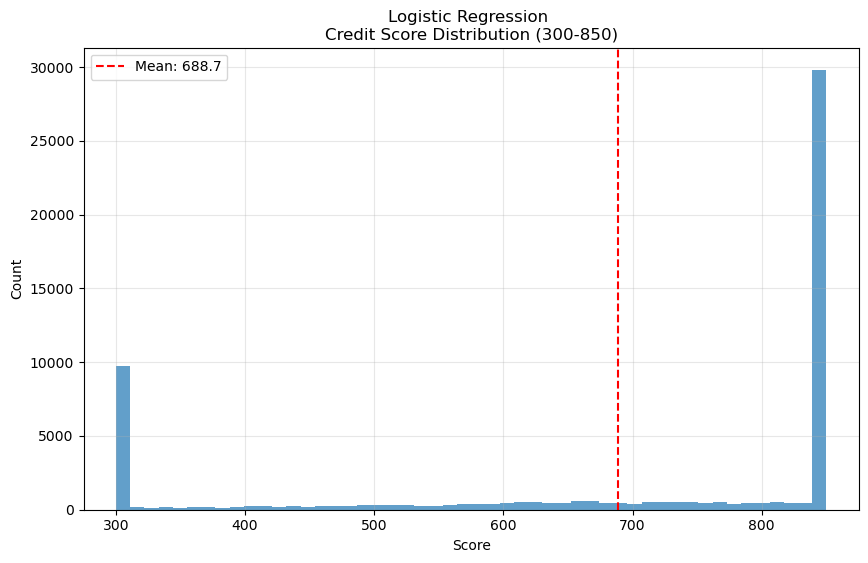

In [39]:
# Calculate scores
test_scores = calculate_score(lr_pred_proba)

# Visualize distribution
plt.figure(figsize=(10, 6))
plt.hist(test_scores, bins=50, alpha=0.7)
plt.axvline(np.mean(test_scores), color='red', linestyle='dashed', 
            label=f'Mean: {np.mean(test_scores):.1f}')
plt.title('Logistic Regression \nCredit Score Distribution (300-850)')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xlim(275, 875)  # Set limits slightly beyond range
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##### **Risk based on Youden's J statistic**

In [40]:
sample_results['Probability_LR'] = lr_pred_proba

lr_threshold, lr_fpr_opt, lr_tpr_opt = find_optimal_threshold(lr_fpr, lr_tpr, lr_thresholds)

# Applying threshold to create categories
sample_results['Risk_Category_J_Statistics_LR_Model'] = np.where(
    sample_results['Probability_LR'] >= lr_threshold,  # Condition
    "Good Loan",  # Value if True (>= threshold)
    "Bad Loan"     # Value if False (< threshold)
)
sample_results['Risk_Category_J_Statistics_LR_Model'].value_counts()

Risk_Category_J_Statistics_LR_Model
Good Loan    43470
Bad Loan     13157
Name: count, dtype: int64

In [41]:
sample_results['Score_LR'] = test_scores
sample_results['Risk Category LR'] = [interpret_score(score) for score in test_scores]
# print(sample_results[['Probability', 'Score', 'Risk Category']])
sample_results.tail(10)

,installment,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,debt_settlement_flag,int_rate%,time_since_last_payment,time_since_last_credit_pull,recovery_ratio,late_fee_ratio,Probability_LR,Risk_Category_J_Statistics_LR_Model,Score_LR,Risk Category LR
2519,999.34,22092.640000,22092.64,14567.76,0.0,1159.78,208.7604,999.34,0,17.14,3146,2478,0.052496,0.000000,0.094574,Bad Loan,300,High Risk
100704,283.26,11361.970051,11361.97,6285.51,0.0,314.83,56.6694,283.26,0,16.99,2934,2263,0.027709,0.000000,0.108422,Bad Loan,300,High Risk
33929,270.91,9688.962728,9688.96,8000.00,0.0,0.00,0.0000,2103.48,0,13.35,2993,2934,0.000000,0.000000,0.964099,Good Loan,672,Low Risk
65707,325.17,11524.510001,11524.51,10200.00,0.0,0.00,0.0000,4045.60,0,9.17,3238,1990,0.000000,0.000000,0.999576,Good Loan,850,Low Risk
253766,659.81,23395.703840,23395.70,20000.00,0.0,0.00,0.0000,7573.07,0,11.53,2934,2904,0.000000,0.000000,0.999958,Good Loan,850,Low Risk
252601,544.13,27285.040000,27285.04,9863.51,0.0,5545.33,998.1594,544.13,0,24.50,2478,2263,0.203237,0.000000,0.001945,Bad Loan,300,High Risk
115847,1139.90,11989.230000,11989.23,6016.82,57.0,2890.72,520.3296,1139.90,0,10.64,3085,2993,0.241110,0.004754,0.001478,Bad Loan,300,High Risk
280635,157.13,5177.540000,5177.54,5000.00,0.0,0.00,0.0000,4553.57,0,8.19,3604,1808,0.000000,0.000000,0.999998,Good Loan,850,Low Risk
145882,271.14,14603.490000,14603.49,10413.63,0.0,0.00,0.0000,0.00,0,12.69,1777,1808,0.000000,0.000000,0.998924,Good Loan,850,Low Risk
251104,250.10,14998.240492,14998.24,12000.00,0.0,0.00,0.0000,498.55,0,9.17,1869,1869,0.000000,0.000000,0.999046,Good Loan,850,Low Risk


##### **Visualizing probability Distribution of Logistic Regression**

C:\Users\aarun\AppData\Local\Temp\ipykernel_44028\1580235636.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(lr_pred_proba[y_test == 0], label='Class 0', shade=True)
C:\Users\aarun\AppData\Local\Temp\ipykernel_44028\1580235636.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(lr_pred_proba[y_test == 1], label='Class 1', shade=True)


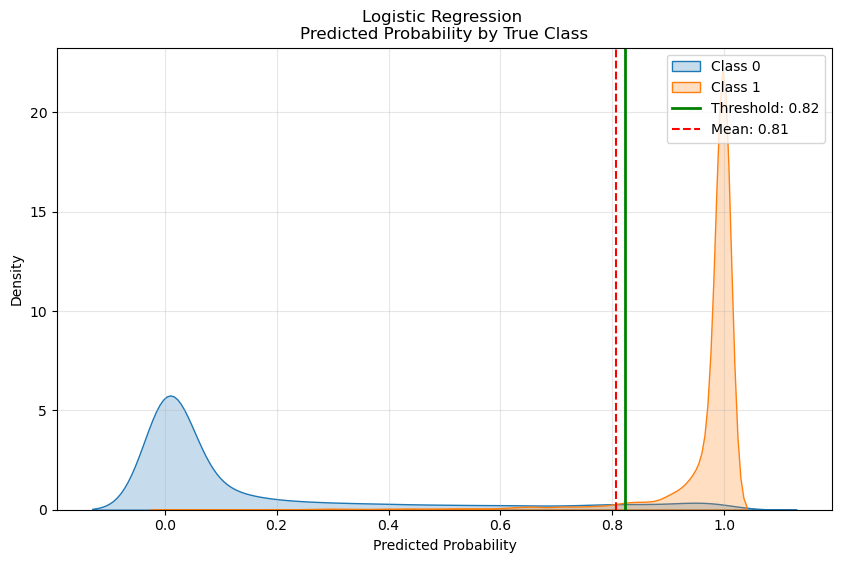

In [42]:
plt.figure(figsize=(10, 6))
sns.kdeplot(lr_pred_proba[y_test == 0], label='Class 0', shade=True)
sns.kdeplot(lr_pred_proba[y_test == 1], label='Class 1', shade=True)
plt.axvline(lr_threshold, color='green', linestyle='-', linewidth=2, label=f'Threshold: {lr_threshold:.2f}')
plt.axvline(np.mean(lr_pred_proba), color='red', linestyle='--', label=f'Mean: {np.mean(lr_pred_proba):.2f}')
plt.title('Logistic Regression \nPredicted Probability by True Class')
plt.xlabel('Predicted Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


##### **Visualizing the Risk Distribution**

Risk Category LR
Low Risk       40422
High Risk      13152
Medium Risk     3053
Name: count, dtype: int64


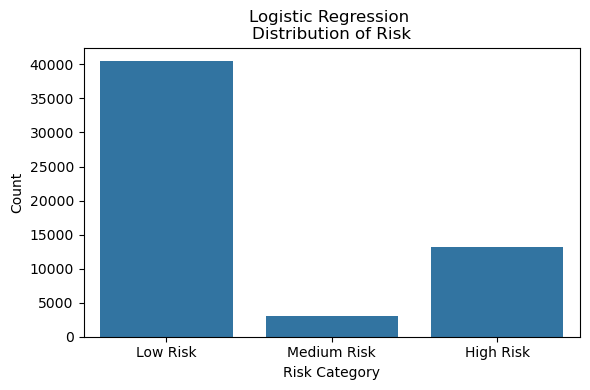

In [43]:
# Check the distribution
print(sample_results['Risk Category LR'].value_counts())

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.countplot(x='Risk Category LR', data=sample_results)
plt.title('Logistic Regression \nDistribution of Risk')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


### **Random Forest**


======= RANDOM FOREST MODEL =======

Random Forest Evaluation Report:
AUC-ROC: 0.9797  AUC-PR: 0.9945  F1: 0.9660

Classification Report:

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.73      0.83     11014
           1       0.94      1.00      0.97     45613

    accuracy                           0.94     56627
   macro avg       0.96      0.86      0.90     56627
weighted avg       0.95      0.94      0.94     56627


Random Forest Confusion Matrix:
[[ 7991  3023]
 [  173 45440]]


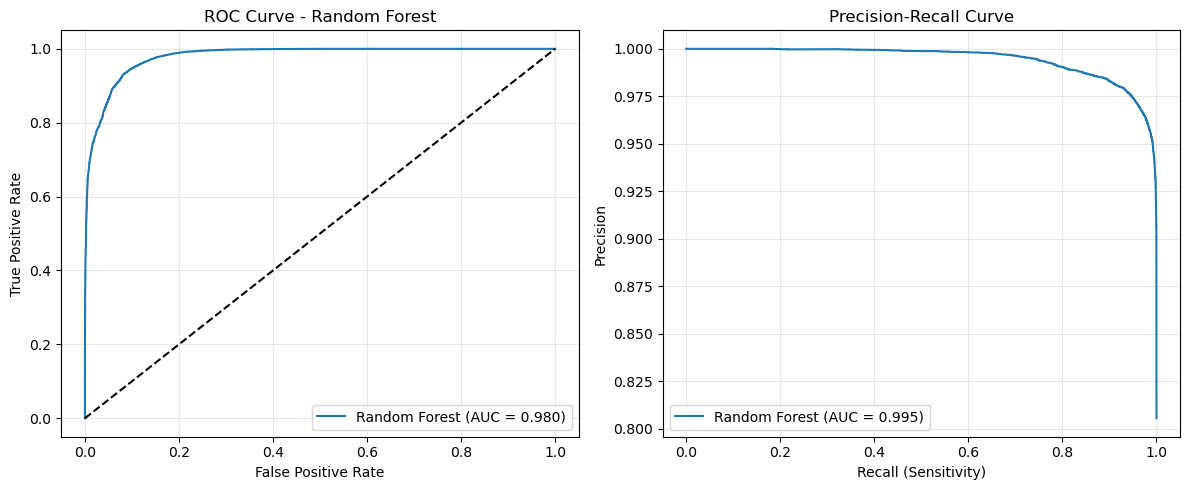


Random Forest Feature Importance:
                        Feature  Importance
3               total_rec_prncp    0.276175
7               last_pymnt_amnt    0.253447
11  time_since_last_credit_pull    0.115437
0                   installment    0.110864
10      time_since_last_payment    0.072315
2               total_pymnt_inv    0.054772
1                   total_pymnt    0.046624
13               late_fee_ratio    0.029631
9                     int_rate%    0.021072
4            total_rec_late_fee    0.019664
5                    recoveries    0.000000
6       collection_recovery_fee    0.000000
8          debt_settlement_flag    0.000000
12               recovery_ratio    0.000000


In [44]:
# 2. Random Forest Model
print("\n======= RANDOM FOREST MODEL =======")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model, rf_auc, rf_pr, rf_fpr, rf_tpr, rf_precision, rf_recall, rf_auc_pr, rf_thresholds, rf_conf_matrix, rf_pred_proba = evaluate_model(rf_model, X_train_binned, X_test_binned, y_train, y_test, "Random Forest")

rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
rf_importance = rf_importance.sort_values('Importance', ascending=False)


print("\nRandom Forest Feature Importance:")
print(rf_importance.head(15))

##### **Ploting Feature Importance based on coefficient provided by the model**

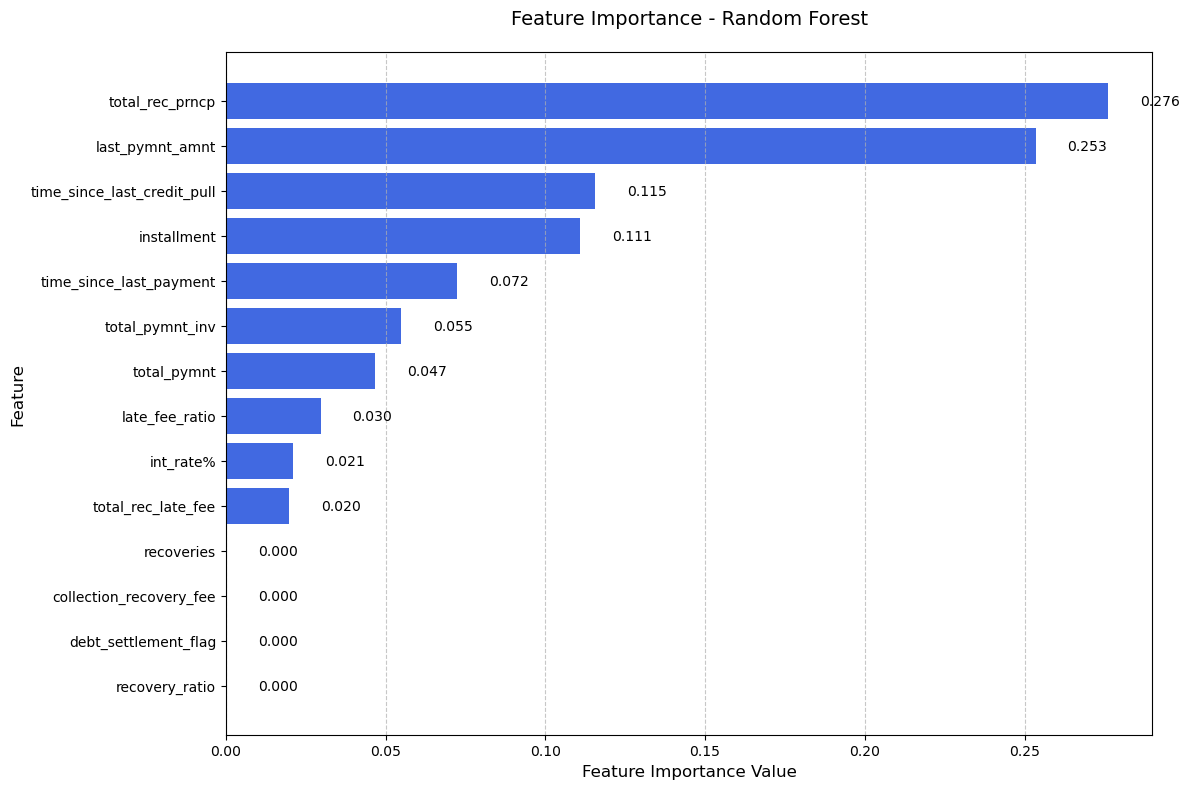

In [45]:
plt.figure(figsize=(12, 8))

# Get all features
top_features = rf_importance.head(15)

# Create horizontal bar plot
bars = plt.barh(top_features['Feature'], 
                top_features['Importance'], 
                color='royalblue')

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             va='center')

# Customize appearance
plt.gca().invert_yaxis()  # highest importance at top
plt.title('Feature Importance - Random Forest', 
          fontsize=14, pad=20)
plt.xlabel('Feature Importance Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

##### **Shap to visualize Local and Global Importance of Features**

In [ ]:
# 1. Create explainer
explainer = shap.TreeExplainer(rf_model, X_train_binned)

# 2. Get SHAP values (returns Explanation object)
shap_values = explainer(X_test_binned)  

100%|===================| 113187/113254 [08:37<00:00]        

##### **Visualizing local and global importance**

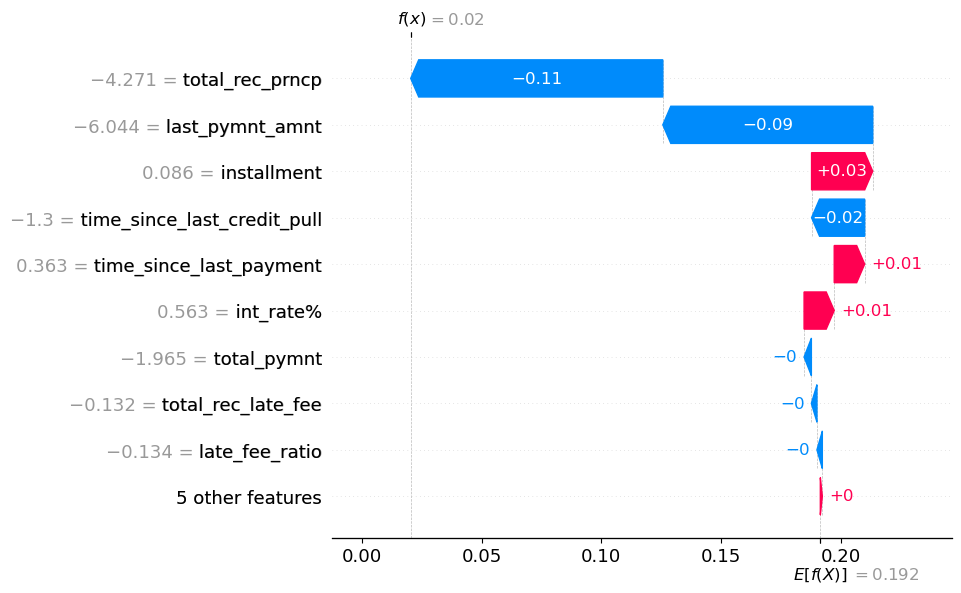

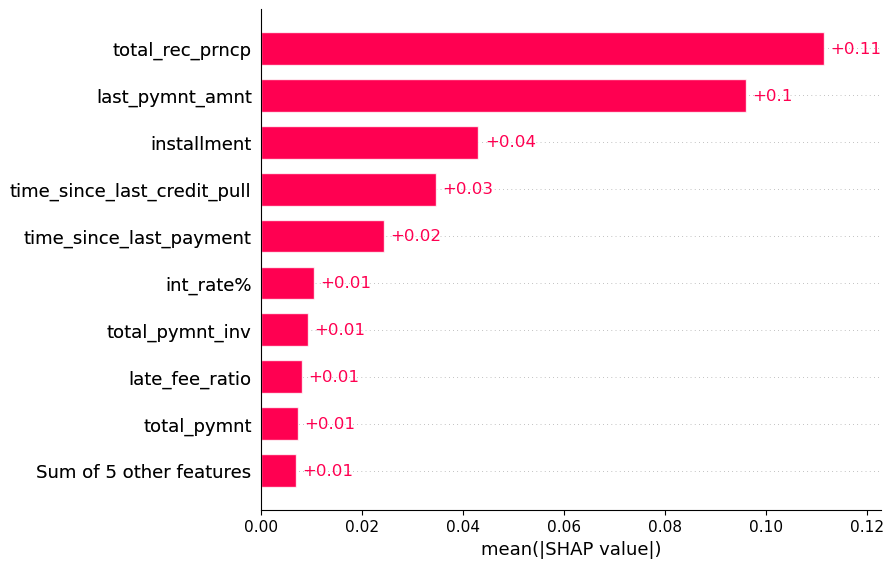

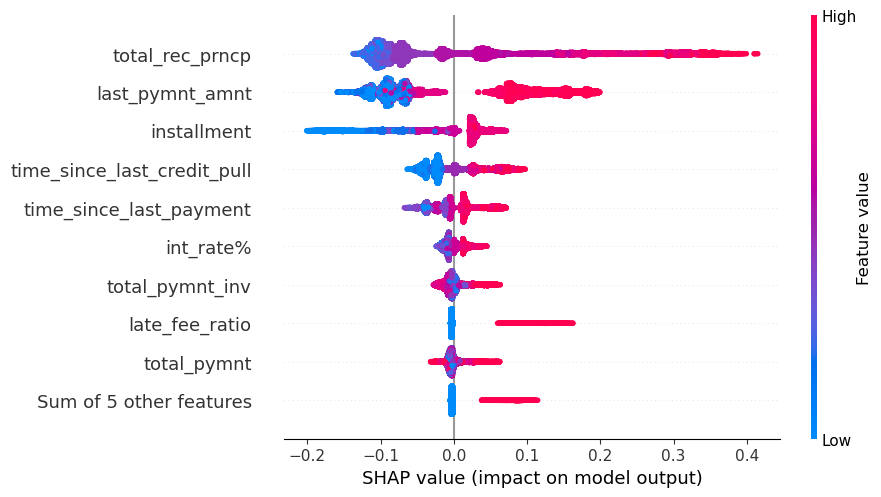

In [ ]:
# Visualizations
# Waterfall plot (for a single prediction) 
shap.plots.waterfall(shap_values[0, :, 0])

# Bar plot (global feature importance)
shap.plots.bar(shap_values[:, :, 0])

# Beeswarm plot (detailed distribution of impacts)
shap.plots.beeswarm(shap_values[:, :, 0])

##### **Score Card For Random Forest**

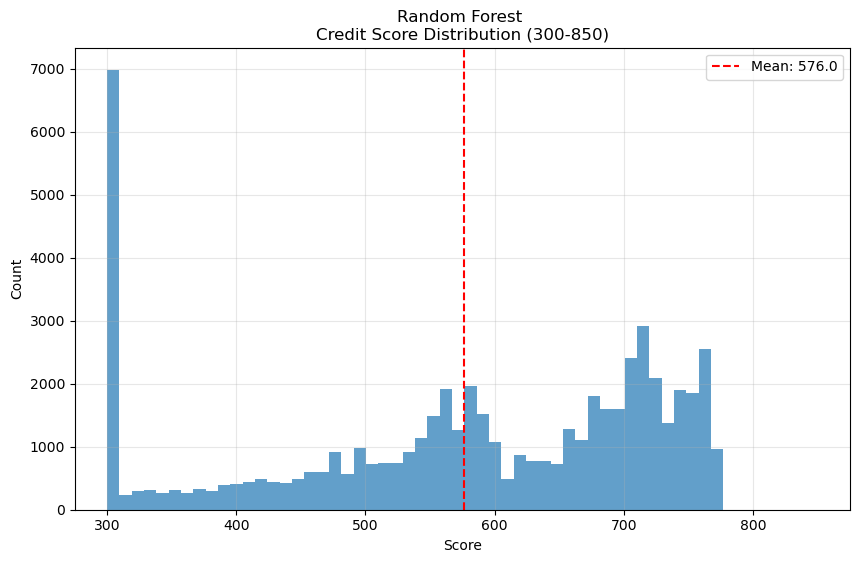

In [66]:
# Calculate scores
test_scores = calculate_score(rf_pred_proba)

# Visualize distribution
plt.figure(figsize=(10, 6))
plt.hist(test_scores, bins=50, alpha=0.7)
plt.axvline(np.mean(test_scores), color='red', linestyle='dashed', 
            label=f'Mean: {np.mean(test_scores):.1f}')
plt.title('Random Forest \nCredit Score Distribution (300-850)')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xlim(275, 875)  # Set limits slightly beyond range
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##### **Risk Category Based on J Statistics**

In [49]:
sample_results['Probability_RF'] = rf_pred_proba

rf_threshold, rf_fpr_opt, rf_tpr_opt = find_optimal_threshold(rf_fpr, rf_tpr, rf_thresholds)

# Apply threshold to create categories
sample_results['Risk_Category_J_Statistics_RF_Model'] = np.where(
    sample_results['Probability_RF'] >= rf_threshold,  # Condition
    "Good Loan",  # Value if True (>= threshold)
    "Bad Loan"     # Value if False (< threshold)
)
sample_results['Risk_Category_J_Statistics_RF_Model'].value_counts()

Risk_Category_J_Statistics_RF_Model
Good Loan    43389
Bad Loan     13238
Name: count, dtype: int64

In [50]:
sample_results['Score_RF'] = test_scores
sample_results['Risk Category RF'] = [interpret_score(score) for score in test_scores]
# print(sample_results[['Probability', 'Score', 'Risk Category']])
sample_results.tail(10)

,installment,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,debt_settlement_flag,int_rate%,...,recovery_ratio,late_fee_ratio,Probability_LR,Risk_Category_J_Statistics_LR_Model,Score_LR,Risk Category LR,Probability_RF,Risk_Category_J_Statistics_RF_Model,Score_RF,Risk Category RF
2519,999.34,22092.640000,22092.64,14567.76,0.0,1159.78,208.7604,999.34,0,17.14,...,0.052496,0.000000,0.094574,Bad Loan,300,High Risk,0.513587,Bad Loan,355,High Risk
100704,283.26,11361.970051,11361.97,6285.51,0.0,314.83,56.6694,283.26,0,16.99,...,0.027709,0.000000,0.108422,Bad Loan,300,High Risk,0.578247,Bad Loan,381,High Risk
33929,270.91,9688.962728,9688.96,8000.00,0.0,0.00,0.0000,2103.48,0,13.35,...,0.000000,0.000000,0.964099,Good Loan,672,Low Risk,0.926507,Good Loan,598,Medium Risk
65707,325.17,11524.510001,11524.51,10200.00,0.0,0.00,0.0000,4045.60,0,9.17,...,0.000000,0.000000,0.999576,Good Loan,850,Low Risk,0.984522,Good Loan,757,Low Risk
253766,659.81,23395.703840,23395.70,20000.00,0.0,0.00,0.0000,7573.07,0,11.53,...,0.000000,0.000000,0.999958,Good Loan,850,Low Risk,0.973249,Good Loan,702,Low Risk
252601,544.13,27285.040000,27285.04,9863.51,0.0,5545.33,998.1594,544.13,0,24.50,...,0.203237,0.000000,0.001945,Bad Loan,300,High Risk,0.547142,Bad Loan,369,High Risk
115847,1139.90,11989.230000,11989.23,6016.82,57.0,2890.72,520.3296,1139.90,0,10.64,...,0.241110,0.004754,0.001478,Bad Loan,300,High Risk,0.202732,Bad Loan,300,High Risk
280635,157.13,5177.540000,5177.54,5000.00,0.0,0.00,0.0000,4553.57,0,8.19,...,0.000000,0.000000,0.999998,Good Loan,850,Low Risk,0.969440,Good Loan,689,Low Risk
145882,271.14,14603.490000,14603.49,10413.63,0.0,0.00,0.0000,0.00,0,12.69,...,0.000000,0.000000,0.998924,Good Loan,850,Low Risk,0.972451,Good Loan,699,Low Risk
251104,250.10,14998.240492,14998.24,12000.00,0.0,0.00,0.0000,498.55,0,9.17,...,0.000000,0.000000,0.999046,Good Loan,850,Low Risk,0.925792,Good Loan,597,Medium Risk


##### **Visualizing Risk Category**

Risk Category RF
Low Risk       27788
High Risk      15955
Medium Risk    12884
Name: count, dtype: int64


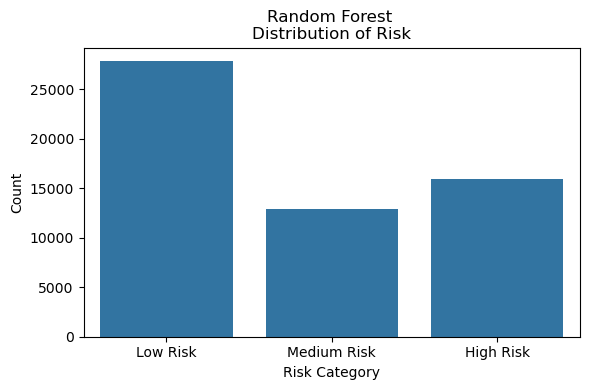

In [51]:
# Check the distribution
print(sample_results['Risk Category RF'].value_counts())

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.countplot(x='Risk Category RF', data=sample_results)
plt.title('Random Forest \nDistribution of Risk')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### **XGBoost Model**


======= XGBOOST MODEL =======

XGBoost Evaluation Report:
AUC-ROC: 0.9914  AUC-PR: 0.9977  F1: 0.9821

Classification Report:

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     11014
           1       0.97      0.99      0.98     45613

    accuracy                           0.97     56627
   macro avg       0.97      0.93      0.95     56627
weighted avg       0.97      0.97      0.97     56627


XGBoost Confusion Matrix:
[[ 9619  1395]
 [  260 45353]]


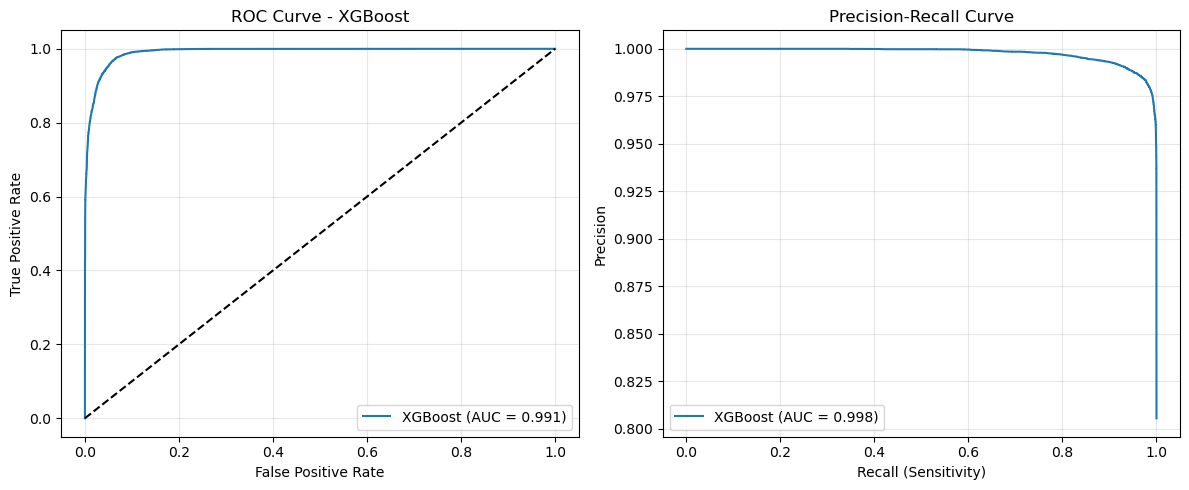


XGBoost Feature Importance:
                        Feature  Importance
10      time_since_last_payment    0.202356
7               last_pymnt_amnt    0.189323
3               total_rec_prncp    0.165184
0                   installment    0.129789
11  time_since_last_credit_pull    0.107819
2               total_pymnt_inv    0.056784
13               late_fee_ratio    0.053575
4            total_rec_late_fee    0.044156
1                   total_pymnt    0.029686
9                     int_rate%    0.021327
5                    recoveries    0.000000
6       collection_recovery_fee    0.000000
8          debt_settlement_flag    0.000000
12               recovery_ratio    0.000000


In [ ]:
#XGBoost Model
print("\n======= XGBOOST MODEL =======")
xgb_model = xgb.XGBClassifier(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42
)
xgb_model, xgb_auc, xgb_pr, xgb_fpr, xgb_tpr, xgb_precision, xgb_recall, xgb_auc_pr, xgb_thresholds, xgb_conf_matrix, xgb_pred_proba = evaluate_model(xgb_model, X_train_binned, X_test_binned, y_train, y_test, "XGBoost")

# Get feature importance for XGBoost
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
})
xgb_importance = xgb_importance.sort_values('Importance', ascending=False)

print("\nXGBoost Feature Importance:")
print(xgb_importance.head(15))

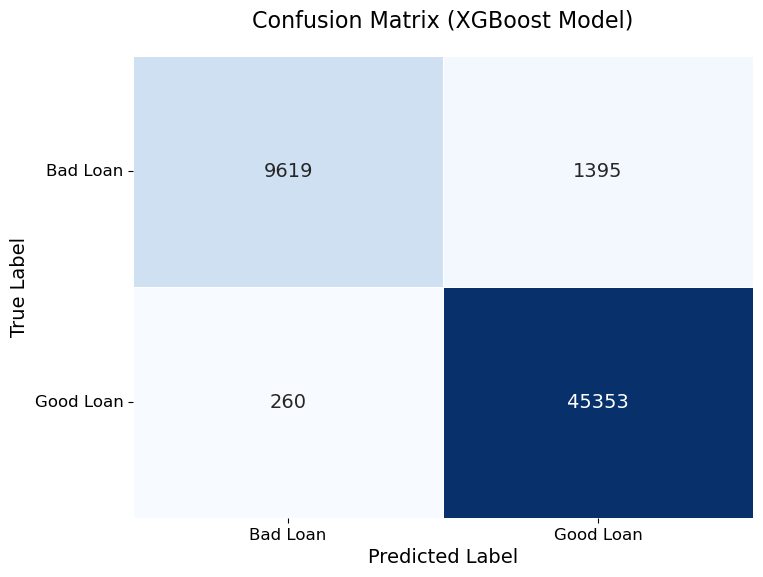

In [ ]:
# Plot with annotations and styling
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_conf_matrix, 
            annot=True, 
            fmt='d',          
            cmap='Blues',      # Color map
            cbar=False,       # Hide color bar
            linewidths=0.5,   
            annot_kws={'size': 14})  # Annotation size

# Customizing labels
class_names = ['Bad Loan', 'Good Loan'] 
plt.xticks(ticks=[0.5, 1.5], labels=class_names, fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=class_names, fontsize=12, rotation=0)

# Adding titles and axis labels
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix (XGBoost Model)', fontsize=16, pad=20)

plt.show()

##### **Visualize the Feature Importance**

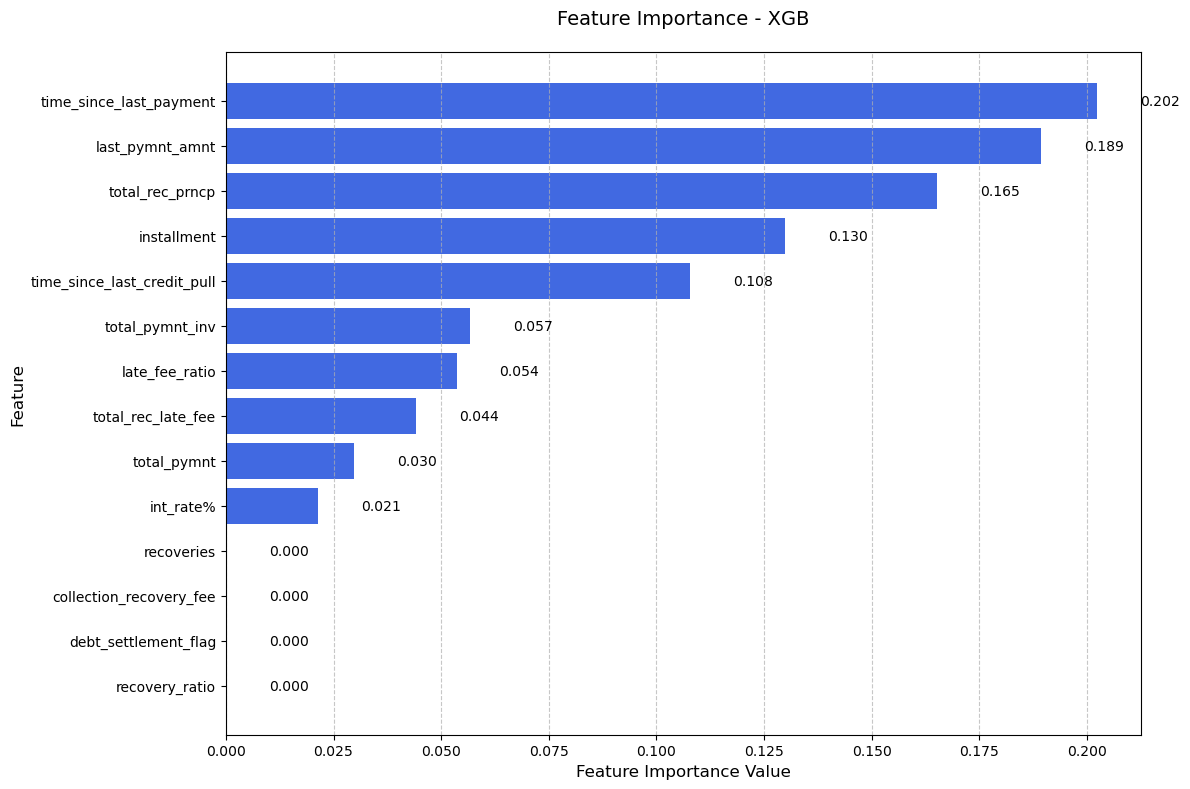

In [54]:
plt.figure(figsize=(12, 8))

# Get all features
top_features = xgb_importance.head(15)

# Create horizontal bar plot
bars = plt.barh(top_features['Feature'], 
                top_features['Importance'], 
                color='royalblue')

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             va='center')

# Customize appearance
plt.gca().invert_yaxis()  # highest importance at top
plt.title('Feature Importance - XGB', 
          fontsize=14, pad=20)
plt.xlabel('Feature Importance Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

##### **Shap Visualization for local and global importance**

In [ ]:
explainer = shap.TreeExplainer(xgb_model, X_train_binned)

shap_values = explainer(X_test_binned)  

100%|===================| 56541/56627 [01:59<00:00]        

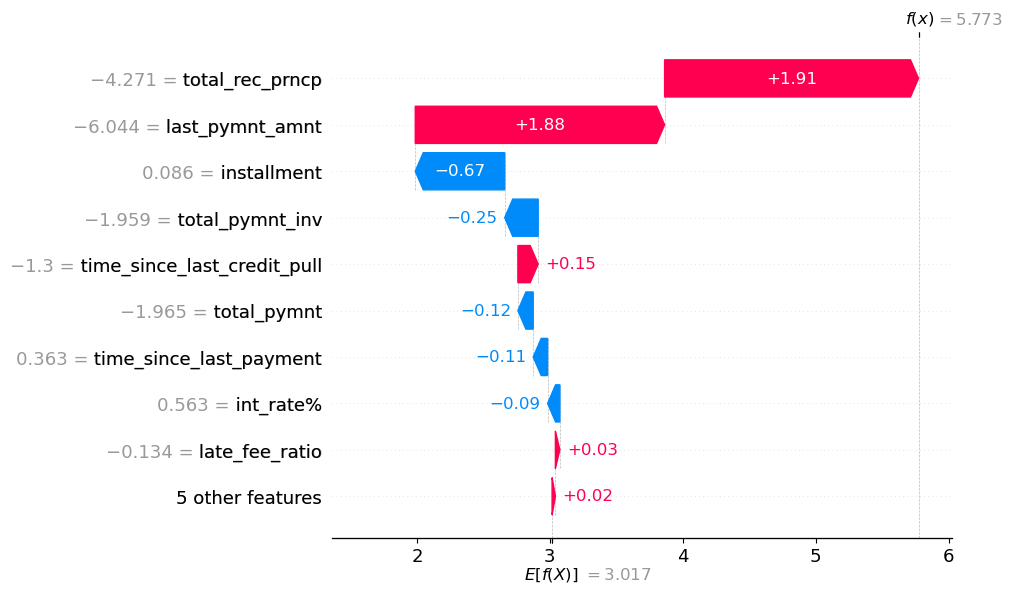

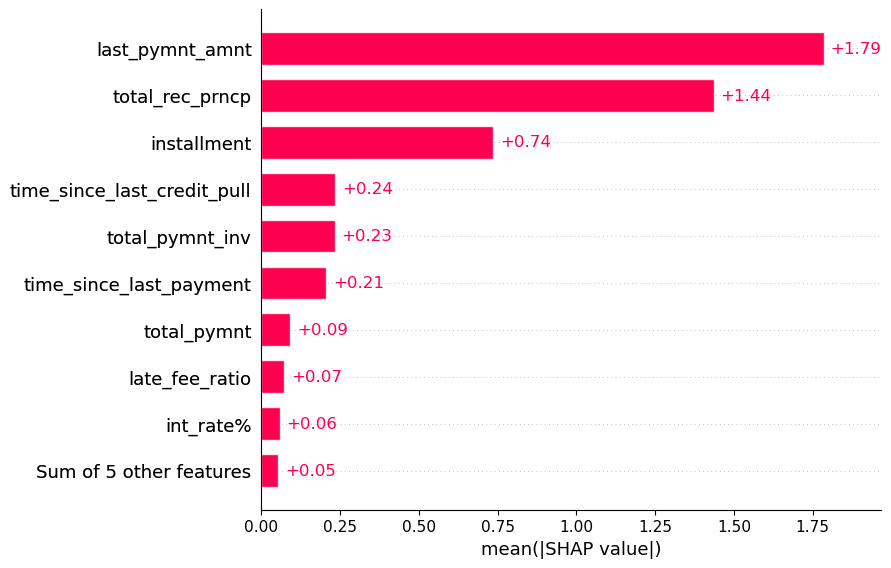

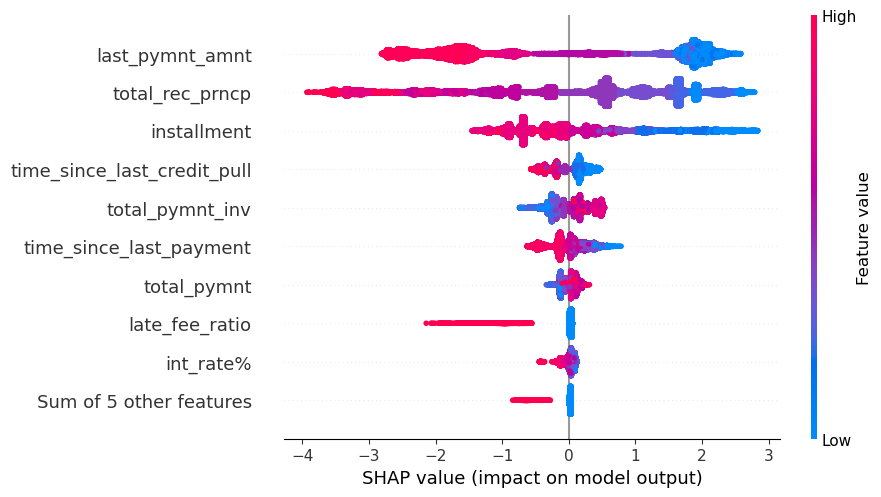

In [ ]:
# Visualizations
# Waterfall plot (for a single prediction)
shap.plots.waterfall(shap_values[0])  

# Bar plot (global feature importance)
shap.plots.bar(shap_values)

# Beeswarm plot (detailed distribution of impacts)
shap.plots.beeswarm(shap_values)

##### **Scorecard for XGBoost Model**

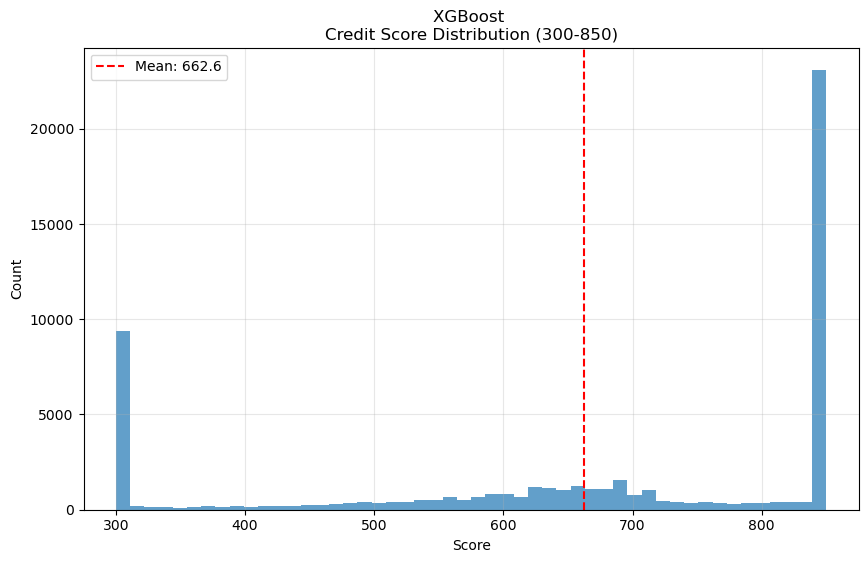

In [ ]:
# Calculate scores
test_scores = calculate_score(xgb_pred_proba)

# Visualize distribution
plt.figure(figsize=(10, 6))
plt.hist(test_scores, bins=50, alpha=0.7)
plt.axvline(np.mean(test_scores), color='red', linestyle='dashed', 
            label=f'Mean: {np.mean(test_scores):.1f}')
plt.title('XGBoost \nCredit Score Distribution (300-850)')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xlim(275, 875) 
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sample_results['Probability_XGB'] = xgb_pred_proba

xgb_threshold, xgb_fpr_opt, xgb_tpr_opt = find_optimal_threshold(xgb_fpr, xgb_tpr, xgb_thresholds)

# Apply threshold to create categories
sample_results['Risk_Category_J_Statistics_XGB_Model'] = np.where(
    sample_results['Probability_XGB'] >= xgb_threshold,  
    "Good Loan",  # Value if True (>= threshold)
    "Bad _Loan"     # Value if False (< threshold)
)
sample_results['Risk_Category_J_Statistics_XGB_Model'].value_counts()

Risk_Category_J_Statistics_XGB_Model
Good Loan    45316
Bad _Loan    11311
Name: count, dtype: int64

In [ ]:
sample_results['Score_XGB'] = test_scores
sample_results['Risk Category XGB'] = [interpret_score(score) for score in test_scores]
sample_results.tail(10)

,installment,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,debt_settlement_flag,int_rate%,...,Score_LR,Risk Category LR,Probability_RF,Risk_Category_J_Statistics_RF_Model,Score_RF,Risk Category RF,Probability_XGB,Risk_Category_J_Statistics_XGB_Model,Score_XGB,Risk Category XGB
2519,999.34,22092.640000,22092.64,14567.76,0.0,1159.78,208.7604,999.34,0,17.14,...,300,High Risk,0.513587,Bad Loan,355,High Risk,0.075852,Bad _Loan,300,High Risk
100704,283.26,11361.970051,11361.97,6285.51,0.0,314.83,56.6694,283.26,0,16.99,...,300,High Risk,0.578247,Bad Loan,381,High Risk,0.307057,Bad _Loan,300,High Risk
33929,270.91,9688.962728,9688.96,8000.00,0.0,0.00,0.0000,2103.48,0,13.35,...,672,Low Risk,0.926507,Good Loan,598,Medium Risk,0.989411,Good Loan,794,Low Risk
65707,325.17,11524.510001,11524.51,10200.00,0.0,0.00,0.0000,4045.60,0,9.17,...,850,Low Risk,0.984522,Good Loan,757,Low Risk,0.997525,Good Loan,850,Low Risk
253766,659.81,23395.703840,23395.70,20000.00,0.0,0.00,0.0000,7573.07,0,11.53,...,850,Low Risk,0.973249,Good Loan,702,Low Risk,0.996272,Good Loan,850,Low Risk
252601,544.13,27285.040000,27285.04,9863.51,0.0,5545.33,998.1594,544.13,0,24.50,...,300,High Risk,0.547142,Bad Loan,369,High Risk,0.133868,Bad _Loan,300,High Risk
115847,1139.90,11989.230000,11989.23,6016.82,57.0,2890.72,520.3296,1139.90,0,10.64,...,300,High Risk,0.202732,Bad Loan,300,High Risk,0.020885,Bad _Loan,300,High Risk
280635,157.13,5177.540000,5177.54,5000.00,0.0,0.00,0.0000,4553.57,0,8.19,...,850,Low Risk,0.969440,Good Loan,689,Low Risk,0.997138,Good Loan,850,Low Risk
145882,271.14,14603.490000,14603.49,10413.63,0.0,0.00,0.0000,0.00,0,12.69,...,850,Low Risk,0.972451,Good Loan,699,Low Risk,0.982599,Good Loan,745,Low Risk
251104,250.10,14998.240492,14998.24,12000.00,0.0,0.00,0.0000,498.55,0,9.17,...,850,Low Risk,0.925792,Good Loan,597,Medium Risk,0.975475,Good Loan,711,Low Risk


##### **Applying Business Rule to categorize the Risk**

Risk Category XGB
Low Risk       38766
High Risk      12949
Medium Risk     4912
Name: count, dtype: int64


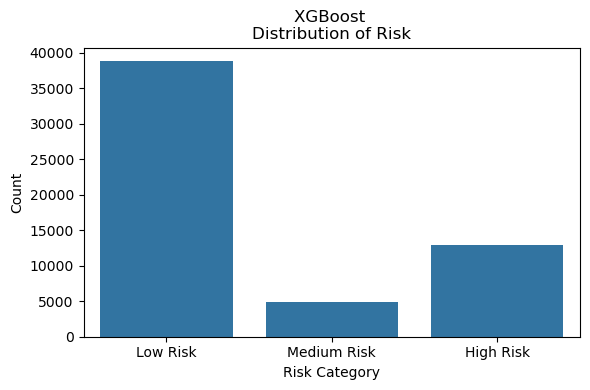

In [60]:
# Check the distribution
print(sample_results['Risk Category XGB'].value_counts())

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.countplot(x='Risk Category XGB', data=sample_results)
plt.title('XGBoost \nDistribution of Risk')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### **Comparing Models**

C:\Users\aarun\AppData\Local\Temp\ipykernel_44028\2604573007.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pred_proba[y_test == 0], label='Class 0', shade=True, color=colors['class0'], ax=ax)
C:\Users\aarun\AppData\Local\Temp\ipykernel_44028\2604573007.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pred_proba[y_test == 1], label='Class 1', shade=True, color=colors['class1'], ax=ax)
C:\Users\aarun\AppData\Local\Temp\ipykernel_44028\2604573007.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pred_proba[y_test == 0], label='Class 0', shade=True, color=colors['class0'], ax=ax)
C:\Users\aarun\AppData\Local\Te

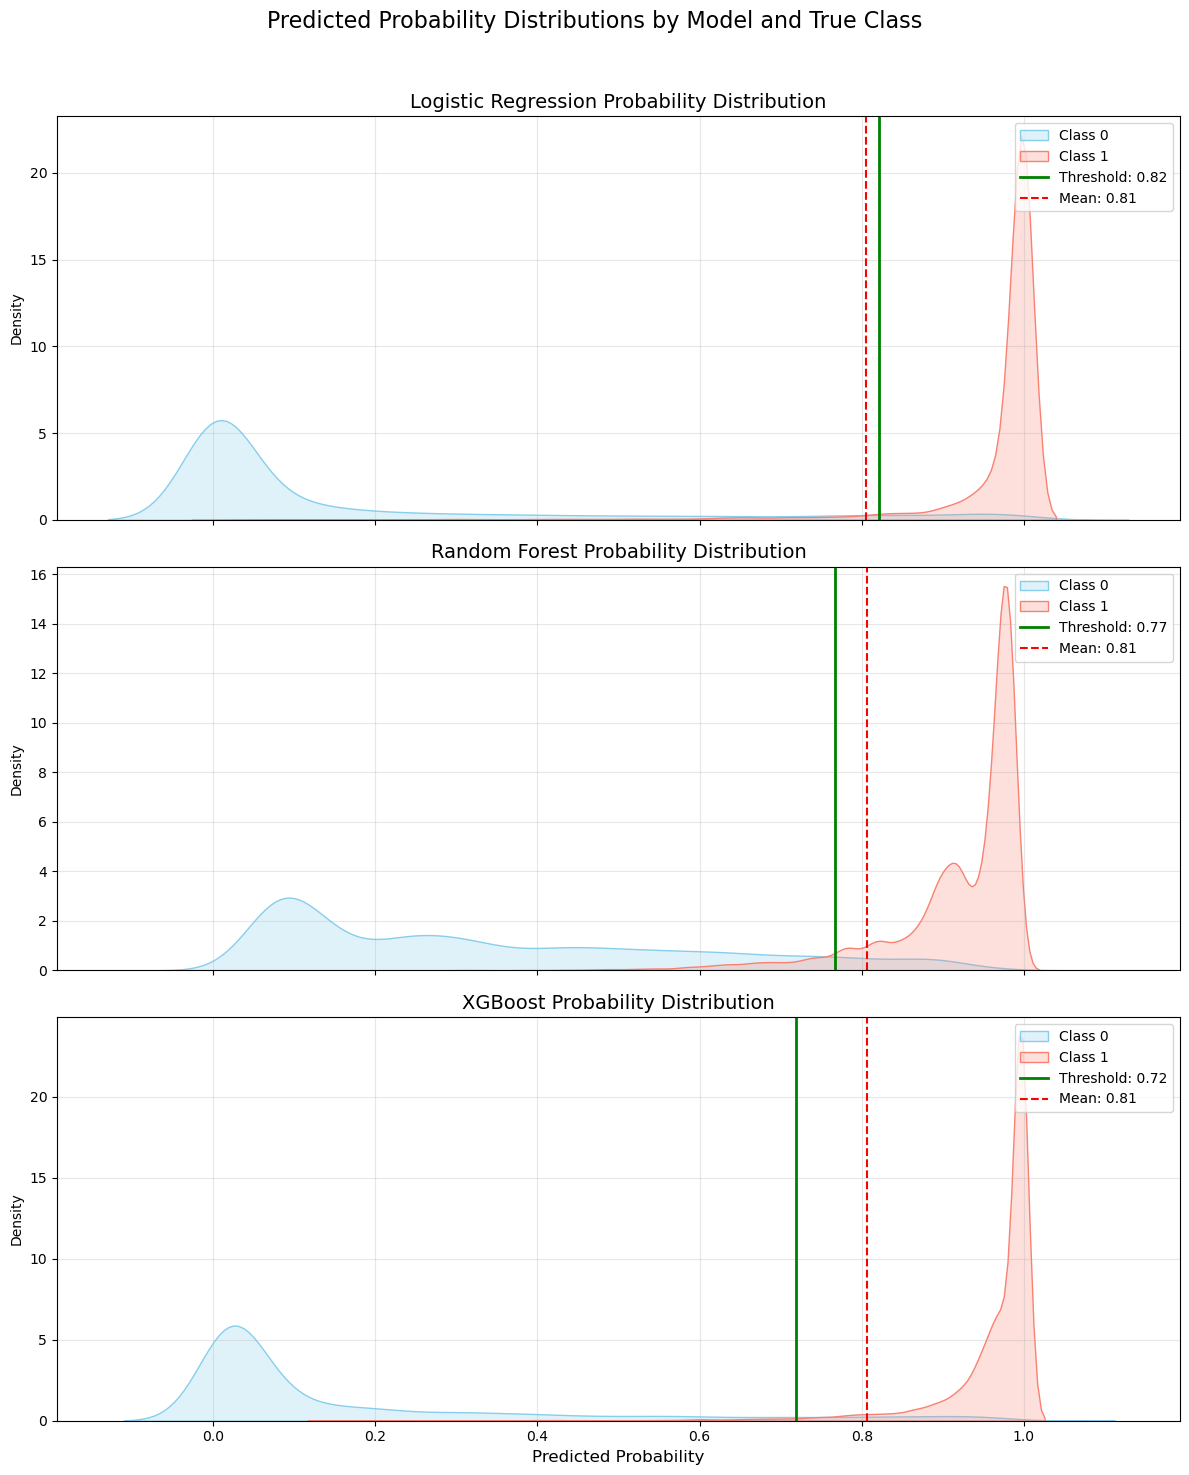

In [61]:
# Create separate plots for each model to avoid overcrowding
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle('Predicted Probability Distributions by Model and True Class', fontsize=16)

# Define a color palette for consistency
colors = {'class0': 'skyblue', 'class1': 'salmon', 'threshold': 'green', 'mean': 'red'}

# Model names for titles
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
pred_probas = [lr_pred_proba, rf_pred_proba, xgb_pred_proba]
thresholds = [lr_threshold, rf_threshold, xgb_threshold]

# Plot each model in its own subplot
for i, (model_name, pred_proba, threshold, ax) in enumerate(zip(model_names, pred_probas, thresholds, axes)):
    # Plot distributions
    sns.kdeplot(pred_proba[y_test == 0], label='Class 0', shade=True, color=colors['class0'], ax=ax)
    sns.kdeplot(pred_proba[y_test == 1], label='Class 1', shade=True, color=colors['class1'], ax=ax)
    
    # Add threshold and mean lines
    ax.axvline(threshold, color=colors['threshold'], linestyle='-', linewidth=2, 
               label=f'Threshold: {threshold:.2f}')
    ax.axvline(np.mean(pred_proba), color=colors['mean'], linestyle='--', 
               label=f'Mean: {np.mean(pred_proba):.2f}')
    
    # Add labels and styling
    ax.set_title(f'{model_name} Probability Distribution', fontsize=14)
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

# Set common x-axis label
plt.xlabel('Predicted Probability', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.show()

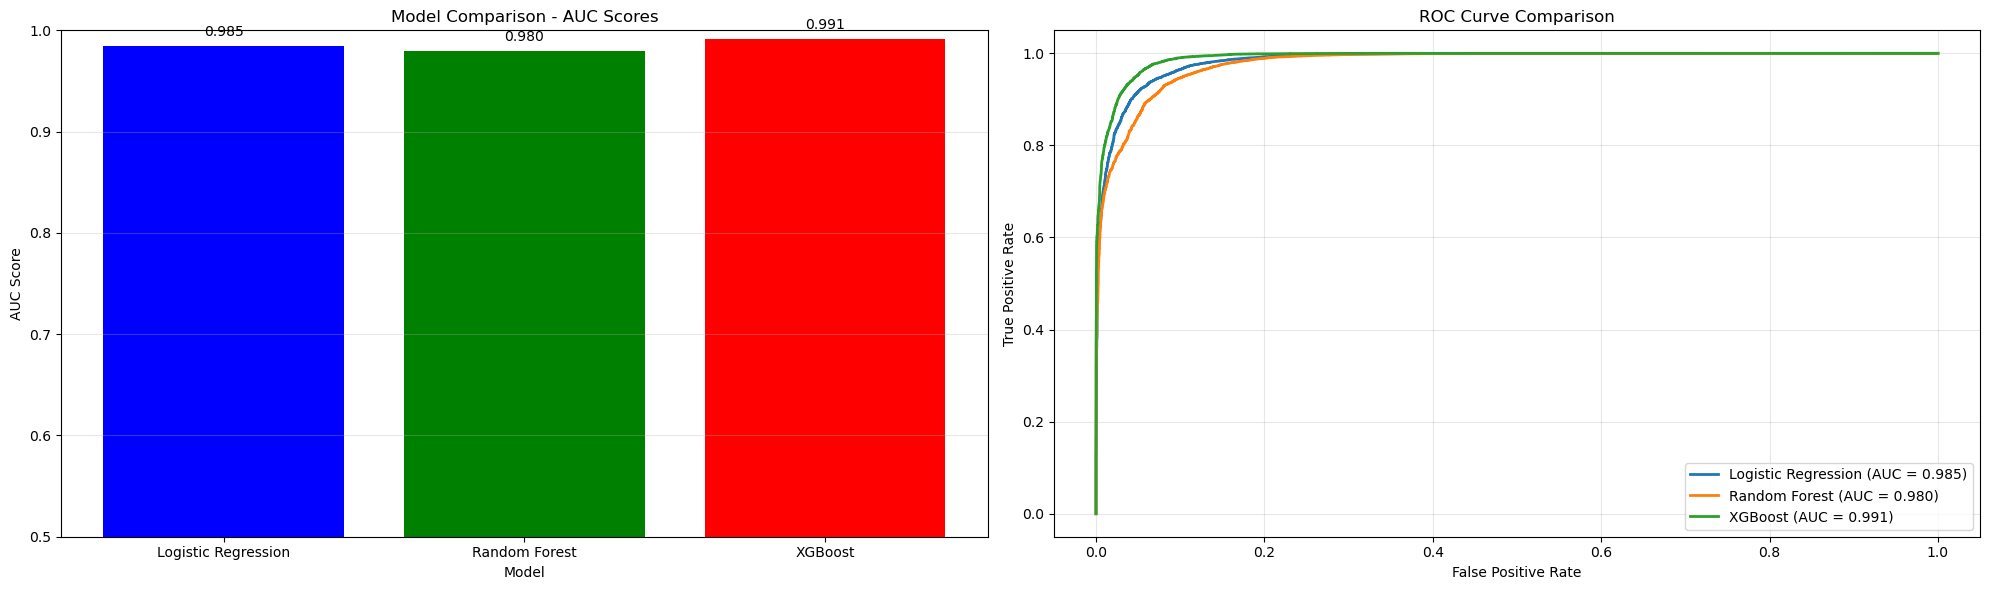

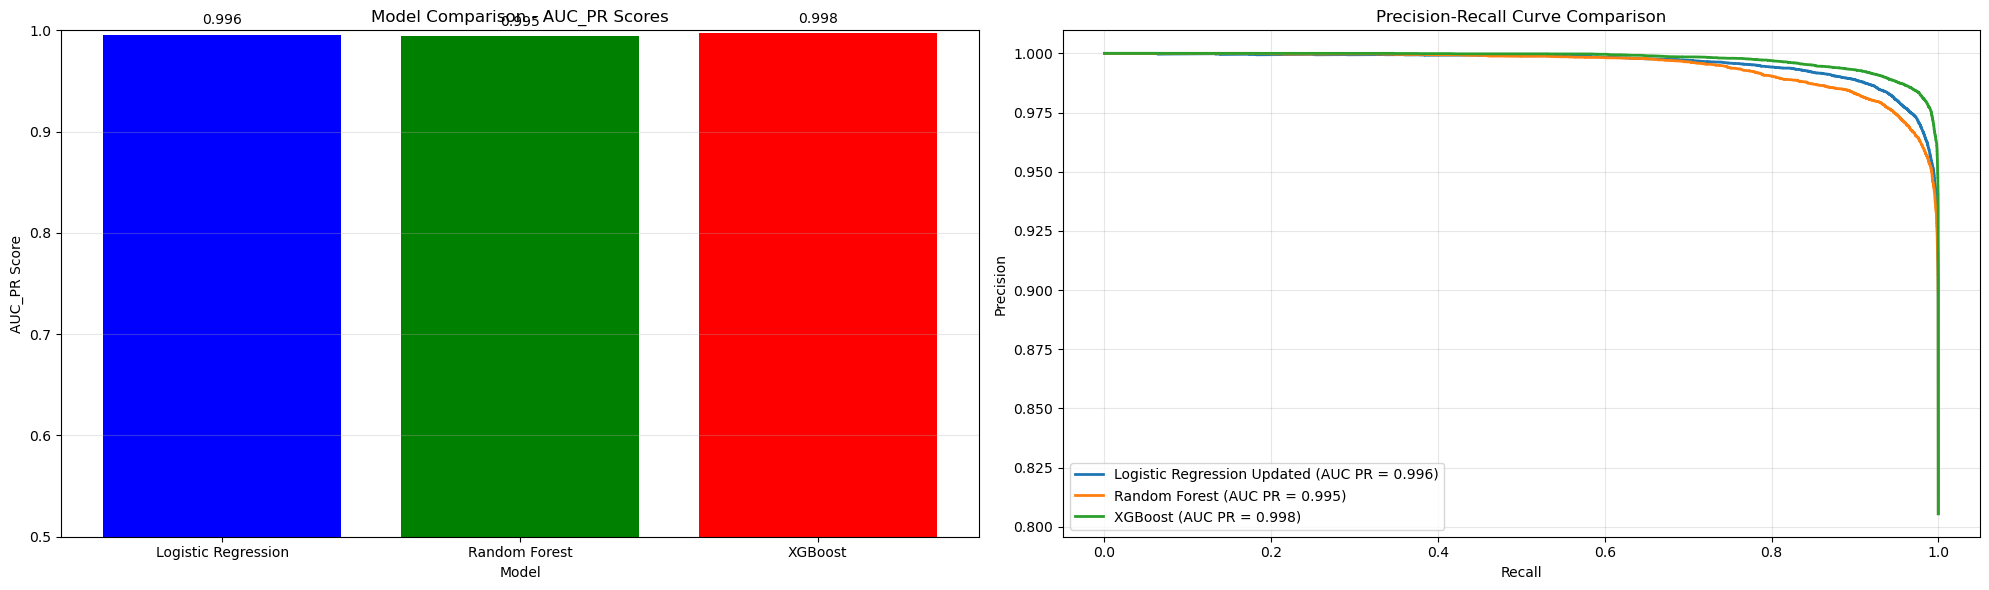

In [ ]:
#  Compare models
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
auc_scores = [lr_auc, rf_auc, xgb_auc]
recall_scores = [lr_pr, rf_pr, xgb_pr]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Bar plot for AUC scores
ax1.bar(models, auc_scores, color=['blue', 'green', 'red'])
ax1.set_ylim(0.5, 1.0)
ax1.set_xlabel('Model')
ax1.set_ylabel('AUC Score')
ax1.set_title('Model Comparison - AUC Scores')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(auc_scores):
    ax1.text(i, v + 0.01, f"{v:.3f}", ha='center')

# ROC curves
# Logistic Regression
ax2.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.3f})', linewidth=2)

# Random Forest
ax2.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.3f})', linewidth=2)

# XGBoost
ax2.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.3f})', linewidth=2)

ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve Comparison')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Similarly for the PR curve and recall scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Bar plot for recall scores
ax1.bar(models, recall_scores, color=['blue', 'green', 'red'])
ax1.set_ylim(0.5, 1.0)
ax1.set_xlabel('Model')
ax1.set_ylabel('AUC_PR Score')
ax1.set_title('Model Comparison - AUC_PR Scores')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(recall_scores):
    ax1.text(i, v + 0.01, f"{v:.3f}", ha='center')

# PR curves
auc_lr_pr = average_precision_score(y_test, lr_pred_proba)
ax2.plot(lr_recall, lr_precision, label=f'Logistic Regression Updated (AUC PR = {lr_auc_pr:.3f})', linewidth=2)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_pred_proba)
ax2.plot(rf_recall, rf_precision, label=f'Random Forest (AUC PR = {rf_auc_pr:.3f})', linewidth=2)

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_pred_proba)
ax2.plot(xgb_recall, xgb_precision, label=f'XGBoost (AUC PR = {xgb_auc_pr:.3f})', linewidth=2)


ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve Comparison')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [63]:
print(f"Logistic Regression: Threshold = {lr_threshold:.3f}, TPR = {lr_tpr_opt:.3f}, FPR = {lr_fpr_opt:.3f}")
print(f"Random Forest: Threshold = {rf_threshold:.3f}, TPR = {rf_tpr_opt:.3f}, FPR = {rf_fpr_opt:.3f}")
print(f"XGBoost: Threshold = {xgb_threshold:.3f}, TPR = {xgb_tpr_opt:.3f}, FPR = {xgb_fpr_opt:.3f}")

Logistic Regression: Threshold = 0.822, TPR = 0.938, FPR = 0.064
Random Forest: Threshold = 0.767, TPR = 0.931, FPR = 0.082
XGBoost: Threshold = 0.719, TPR = 0.977, FPR = 0.068
